# Yelp Rating Prediction FCNN

Author: Rahul Gupta

Goal of the project is to develop an FCNN (Fully Connected Neural Network) to predict Yelp rating scores based on the text data from user-written reviews.

## Data Loading
Need to first load, understand, and preprocess data for the neural network.

In [2]:
import numpy as np
import pandas as pd

# Starter code
business = pd.read_json('./data/yelp_academic_dataset_business.json', lines=True, nrows= 1000000)

In [3]:
business.dropna(inplace=True)
business_filtered = business[business['review_count'] >= 20]
print(business_filtered.shape)
business_filtered.head()

(55815, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [4]:
# Get all reviews for businesses in business_filtered
business_ids = set(business_filtered['business_id'])

review_chunk = 1000000
review_filtered = pd.DataFrame()

# Use chunking for performance
review_chunk_iter = pd.read_json('./data/yelp_academic_dataset_review.json', lines=True, chunksize=review_chunk)

# Getting all reviews for businesses that have over 20 reviews
for chunk in review_chunk_iter:
    chunk_filtered = chunk[chunk['business_id'].isin(business_ids)]
    review_filtered = pd.concat([review_filtered, chunk_filtered])

print(review_filtered.shape)

(5820216, 9)


## Preprocess

Join the tables together such that we have a business and all the reviews for each business in one row.

We'll use TFIDF on all the reviews for a business to predict the business's rating.

In [5]:
df_review_agg = review_filtered.groupby('business_id')['text'].sum()

df_grouped = pd.DataFrame({
    'business_id': df_review_agg.index, 
    'all_reviews': df_review_agg.values,
    })

# Join the business star ratings w/ business IDs
# Normalize the star ratings
df_grouped = df_grouped.merge(business_filtered[['business_id', 'stars']], on='business_id', how='inner')
df_grouped['stars'] = df_grouped['stars']

print(df_grouped.shape)
df_grouped.head()

(55815, 3)


,business_id,all_reviews,stars
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...,4.5
1,--8IbOsAAxjKRoYsBFL-PA,"Took me for 40 bucks through grubhub, no call ...",3.0
2,--9osgUCSDUWUkoTLdvYhQ,I loved this!!!! I was set up on a blind date ...,5.0
3,--ARBQr1WMsTWiwOKOj-FQ,What a great neighborhood place to wine it up....,4.5
4,--MbOh2O1pATkXa7xbU6LA,I always pass the sign for sweet lizard on my ...,4.0


## RMSE Function

In [6]:
from sklearn import metrics

# Predict and measure RMSE
def print_rsme(model, x_test, y_test):
    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    
    print("RMSE Score: {}".format(score))


## Lift Chart Function

In [17]:
# Function from lab #4
import matplotlib.pyplot as plt

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    
    b = plt.plot(t['pred'].tolist(),label='prediction')
    a = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot the chart
# chart_regression(pred.flatten(),y_test, sort=True)

## Applying TFIDF
Use TFIDF on review text to extract relevant features. Ignore stop words. Found that a large number of TFIDF features worked best.

In [8]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=10000, min_df=1, max_df=0.95)

x = vectorizer.fit_transform(df_grouped['all_reviews'])
y = df_grouped[['stars']].to_numpy()

In [9]:
vectorizer.get_feature_names_out()[:40]

array(['00', '000', '00am', '00pm', '01', '02', '05', '07', '08', '09',
       '10', '100', '1000', '101', '10am', '10pm', '10th', '11', '110',
       '11am', '11pm', '11th', '12', '120', '1200', '125', '12pm', '12th',
       '13', '130', '13th', '14', '140', '15', '150', '1500', '15min',
       '15pm', '15th', '16'], dtype=object)

## Train Test Split
Splitting the training and resting data (80/20)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## FCNN Model
Found out through experimentation that a smaller model works better with dropout layers and a large amount of TFIDF features.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential()

model.add(Dense(500, input_dim=x.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# sgd_modified = optimizers.SGD(learning_rate=0.001)

model.compile(loss='mean_squared_error', optimizer='adam')

# Early exit
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)

print_rsme(model, x_test, y_test)

c:\Users\rahgu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
1396/1396 - 62s - 44ms/step - loss: 0.3801 - val_loss: 0.1402
Epoch 2/1000
1396/1396 - 56s - 40ms/step - loss: 0.1944 - val_loss: 0.0891
Epoch 3/1000
1396/1396 - 55s - 40ms/step - loss: 0.1586 - val_loss: 0.0965
Epoch 4/1000
1396/1396 - 55s - 39ms/step - loss: 0.1394 - val_loss: 0.0845
Epoch 5/1000
1396/1396 - 55s - 39ms/step - loss: 0.1194 - val_loss: 0.0897
Epoch 6/1000
1396/1396 - 55s - 39ms/step - loss: 0.1038 - val_loss: 0.0739
Epoch 7/1000
1396/1396 - 55s - 40ms/step - loss: 0.0907 - val_loss: 0.0890
Epoch 8/1000
1396/1396 - 55s - 39ms/step - loss: 0.0788 - val_loss: 0.0834
Epoch 9/1000
1396/1396 - 55s - 39ms/step - loss: 0.0708 - val_loss: 0.0802
Epoch 10/1000
1396/1396 - 55s - 39ms/step - loss: 0.0623 - val_loss: 0.0798
Epoch 11/1000
1396/1396 - 55s - 39ms/step - loss: 0.0561 - val_loss: 0.0789
Epoch 11: early stopping
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
RMSE Score: 0.2809287578771102


In [13]:
print_rsme(model, x_test, y_test)

349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
RMSE Score: 0.2809287578771102


349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


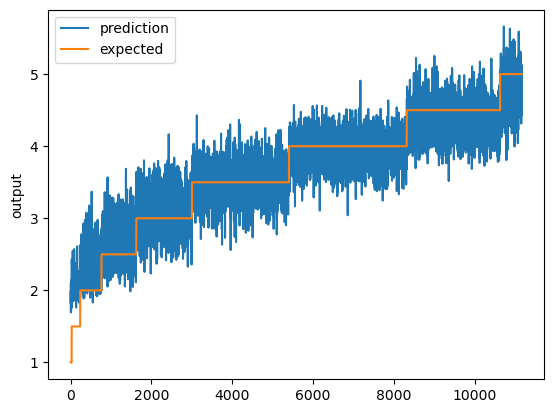

In [18]:
pred = model.predict(x_test)
chart_regression(pred.flatten(), y_test, sort=True)

## Predictions of 5 Businesses
Try the best (TFIDF only) model on 5 businesses

In [28]:
df_5 = df_grouped.merge(business_filtered[['name', 'business_id']], on='business_id', how='inner')
df_5['stars'] = df_grouped['stars']

df_5 = df_5[:5]

print(df_5.shape)
df_5

(5, 4)


,business_id,all_reviews,stars,name
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...,4.5,Frankie's Raw Bar
1,--8IbOsAAxjKRoYsBFL-PA,"Took me for 40 bucks through grubhub, no call ...",3.0,The Original Italian Pie
2,--9osgUCSDUWUkoTLdvYhQ,I loved this!!!! I was set up on a blind date ...,5.0,Will You Escape?
3,--ARBQr1WMsTWiwOKOj-FQ,What a great neighborhood place to wine it up....,4.5,Traveling Corks
4,--MbOh2O1pATkXa7xbU6LA,I always pass the sign for sweet lizard on my ...,4.0,Sweet Lizard


In [29]:
# NOT FIT TRANSFROM, just transform, we fitted already during prev. TFIDF

x_5 = vectorizer.transform(df_5['all_reviews'])
y_5 = df_5[['stars']].to_numpy()

x_5

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2140 stored elements and shape (5, 10000)>

In [30]:
print(x_5.shape)
print(x_test.shape)

pred = model.predict(x_5)

true_stars = df_5['stars']
df_5.drop('stars', axis=1, inplace=True)
df_5.drop('all_reviews', axis=1, inplace=True)

# Reorder so true and predicted are next to each other
df_5['true_stars'] = true_stars
df_5['predicted_stars'] = pred

df_5

(5, 10000)
(11163, 10000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


,business_id,name,true_stars,predicted_stars
0,---kPU91CF4Lq2-WlRu9Lw,Frankie's Raw Bar,4.5,4.410551
1,--8IbOsAAxjKRoYsBFL-PA,The Original Italian Pie,3.0,3.046787
2,--9osgUCSDUWUkoTLdvYhQ,Will You Escape?,5.0,5.165073
3,--ARBQr1WMsTWiwOKOj-FQ,Traveling Corks,4.5,4.732890
4,--MbOh2O1pATkXa7xbU6LA,Sweet Lizard,4.0,3.549117
